In [1]:
import tensorflow as tf
import pandas as pd
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [72]:
# 데이터 다운로드
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [73]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [74]:
# 데이터 크기
print('전체 샘플 수: ', len(data))
print('text의 유니크 샘플 수: ', data['text'].nunique())
print('headlines의 유니크 샘플 수: ', data['headlines'].nunique())
print('빈 셀의 수: ', data.isnull().sum())

전체 샘플 수:  98401
text의 유니크 샘플 수:  98360
headlines의 유니크 샘플 수:  98280
빈 셀의 수:  headlines    0
text         0
dtype: int64


- 중복제거 필요함, 빈 줄 제거 필요 없음.

In [75]:
# 중복제거 - text에 대해서만 수행
data.drop_duplicates(subset=['text'], inplace=True)
print('전체 샘플 수: ', len(data))

전체 샘플 수:  98360


In [76]:
# 영어 풀어쓰기 사전
contractions = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have", 
                "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
                "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would",
                "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have",
                "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
                "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
                "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have",
                "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is",
                "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
                "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
                "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
                "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have",
                "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    #sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [77]:
# 전체 데이터 전처리
clean_text = []
for sentence in data["text"]:
    clean_text.append(preprocess_sentence(sentence))

clean_headlines = []
for sentence in data["headlines"]:
    clean_headlines.append(preprocess_sentence(sentence, False))

data['text'] = clean_text
data['headlines'] = clean_headlines

In [78]:
data.head()

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


text의 최소 길이 : 1
text의 최대 길이 : 60
text의 평균 길이 : 35.09968483123221
headlines의 최소 길이 : 1
headlines의 최대 길이 : 16
headlines의 평균 길이 : 9.299532330215534


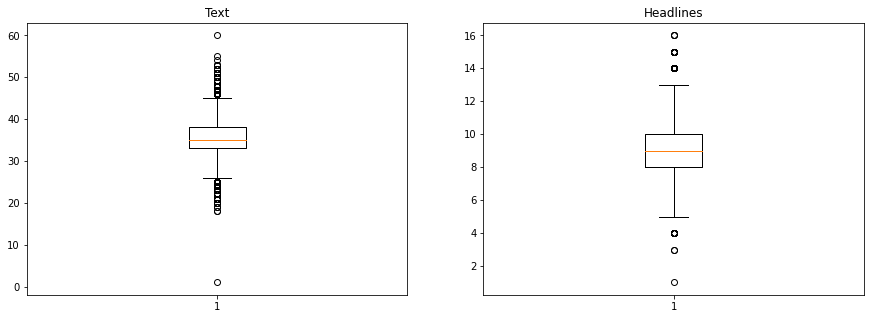

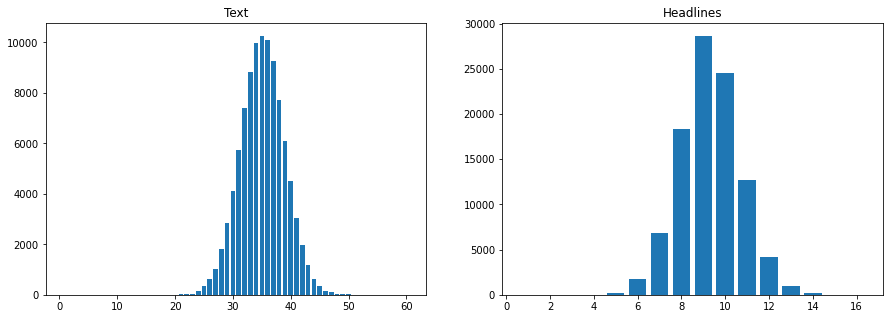

In [79]:
# 길이 분포 출력
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

len_text = [len(s.split()) for s in data['text']]
len_headlines = [len(s.split()) for s in data['headlines']]

print('text의 최소 길이 : {}'.format(np.min(len_text)))
print('text의 최대 길이 : {}'.format(np.max(len_text)))
print('text의 평균 길이 : {}'.format(np.mean(len_text)))
print('headlines의 최소 길이 : {}'.format(np.min(len_headlines)))
print('headlines의 최대 길이 : {}'.format(np.max(len_headlines)))
print('headlines의 평균 길이 : {}'.format(np.mean(len_headlines)))

len_text_counter = Counter(len_text)
len_headlines_counter = Counter(len_headlines)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.boxplot(len_text)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(len_headlines)
plt.title('Headlines')
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(len_text_counter.keys(), len_text_counter.values())
plt.title('Text')
plt.subplot(1,2,2)
plt.bar(len_headlines_counter.keys(), len_headlines_counter.values())
plt.title('Headlines')
plt.show()

In [80]:
# 최대 길이 이용
max_text_len = 60
max_headlines_len = 16

In [81]:
# 데이터셋 준비
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

# 데이터 셔플
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# Train, Test 데이터 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

# 원문 출력을 위해 테스트 데이터만 별도 저장
text_input_test = encoder_input[-n_of_val:]
#text_input_test = decoder_input[-n_of_val:]
text_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

테스트 데이터의 수 : 19672
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [82]:
# 단어 빈도수 분석 함수
def word_freq_analysis(tokenizer, threshold):
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [83]:
# 인덱스 사전 만들기
from tensorflow.keras.preprocessing.text import Tokenizer 

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

word_freq_analysis(src_tokenizer, 6)

단어 집합(vocabulary)의 크기 : 69695
등장 빈도가 5번 이하인 희귀 단어의 수: 45683
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24012
단어 집합에서 희귀 단어의 비율: 65.54702632900495
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.0884522770086633


In [84]:
# 사전 재생성
src_vocab = 25000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [85]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])
print(encoder_input_test[:3])

[[1620, 98, 20, 881, 1082, 188, 2094, 1511, 22197, 559, 17455, 1115, 1776, 1119, 9, 921, 6122, 6054, 592, 99, 20, 1209, 22197, 2926, 1373, 912, 30, 882, 64, 9, 2410, 22197, 1102, 143, 20717, 1165, 13356, 22197], [15412, 12227, 3160, 426, 1365, 1297, 88, 124, 899, 202, 184, 1644, 686, 334, 804, 854, 3, 13, 715, 362, 568, 395, 12572, 656, 17, 2364, 3933, 804, 17, 1827, 1148, 196, 30, 11522, 3114, 596, 472, 394, 508, 12227, 1, 2872, 283], [690, 6884, 4478, 10055, 22198, 309, 44, 4479, 889, 59, 1184, 2302, 728, 5718, 947, 1171, 3504, 183, 771, 126, 890, 4819, 45, 16683, 1, 690, 6723, 1871, 1482, 10, 1294, 3075, 904, 6809, 5339, 762]]
[[1116, 7177, 4422, 121, 19, 318, 14586, 15425, 23, 297, 1753, 2507, 8144, 2068, 18, 36, 18, 335, 114, 121, 5786, 640, 18, 1116, 826, 3613, 7466, 640, 189, 18, 1329, 5370, 33, 31, 1, 8144, 2068, 5118, 9851, 18], [429, 76, 100, 3988, 48, 61, 1, 455, 6681, 245, 21, 2679, 3931, 521, 1075, 1430, 185, 4085, 1078, 24, 604, 112, 21, 8660, 60, 133, 591, 8, 3105, 389, 

In [86]:
# 인덱스 사전 만들기 - 디코더 입력용
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

word_freq_analysis(tar_tokenizer, 6)

단어 집합(vocabulary)의 크기 : 30123
등장 빈도가 5번 이하인 희귀 단어의 수: 19705
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10418
단어 집합에서 희귀 단어의 비율: 65.41513129502373
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.645426389111684


In [87]:
# 사전 재생성
tar_vocab = 10500
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [88]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print(decoder_input_train[:3])
print(decoder_target_train[:3])

[[1, 1598, 555, 3, 714, 4, 3892, 3893, 67, 1310], [1, 473, 1202, 700, 565, 145, 11, 111, 440, 3107, 660, 91], [1, 536, 1203, 18, 550, 2284, 51, 459]]
[[1598, 555, 3, 714, 4, 3892, 3893, 67, 1310, 2], [473, 1202, 700, 565, 145, 11, 111, 440, 3107, 660, 91, 2], [536, 1203, 18, 550, 2284, 51, 459, 2]]


In [89]:
# 문장의 길이기 1인 문장 검사
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [90]:
# pad 삽입
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_train = pad_sequences(encoder_input_train, maxlen=max_text_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=max_text_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_headlines_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=max_headlines_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=max_headlines_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=max_headlines_len, padding='post')

In [91]:
# 모델 만들기
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더
embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# 디코더
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 60, 128)      3200000     input_13[0][0]                   
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 128)    1344000     input_14[0][0]                   
____________________________________________________________________________________________

- input_13 - embedding_4 - lstm_4 연결됨
- input_14 - embedding_5 - lstm_5 - dense_2 연결됨 (lstm_5에 lstm_4의 출력 연결됨)

- embedding_4의 파라미터 수: 128(임베딩 벡터 크기) * 25000(단어 수) = 3,200,000
- embedding_5의 파라미터 수: 128(임베딩 벡터 크기) * 10500(단어 수) = 1,344,000
- lstm_4의 파라미터 수: 4(내부 스테이트) * (128 * 256(W 메트릭스) + 256 * 256(U 메트릭스) + 256(b 벡터)) = 394,240
- lstm_5의 파라미터 수: lstm_4와 동일
- dense_2의 파라미터 수: (256(lstm_5의 출력) + 1(바이어스)) * 10500(타겟 단어수) = 2,698,500

In [92]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 60, 128)      3200000     input_13[0][0]                   
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 128)    1344000     input_14[0][0]                   
____________________________________________________________________________________________

- attention_layer 추가 되었고, lstm_5의 출력과 attention_layer 출력 합쳐서 dense 레이어로 전달 됨
- dense_3의 파라미터: (512 + 1) * 10500 = 5,386,500

In [93]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 33s 98ms/step - loss: 4.3406 - val_loss: 4.0170
Epoch 2/50
308/308 [==============================] - 30s 97ms/step - loss: 3.9027 - val_loss: 3.7274
Epoch 3/50
308/308 [==============================] - 31s 99ms/step - loss: 3.6106 - val_loss: 3.4872
Epoch 4/50
308/308 [==============================] - 31s 99ms/step - loss: 3.3865 - val_loss: 3.3320
Epoch 5/50
308/308 [==============================] - 30s 99ms/step - loss: 3.2251 - val_loss: 3.2180
Epoch 6/50
308/308 [==============================] - 31s 99ms/step - loss: 3.0933 - val_loss: 3.1358
Epoch 7/50
308/308 [==============================] - 31s 99ms/step - loss: 2.9812 - val_loss: 3.0593
Epoch 8/50
308/308 [==============================] - 31s 100ms/step - loss: 2.8829 - val_loss: 3.0082
Epoch 9/50
308/308 [==============================] - 31s 100ms/step - loss: 2.7945 - val_loss: 2.9546
Epoch 10/50
308/308 [==============================] - 31s 99ms/step - loss: 2.7

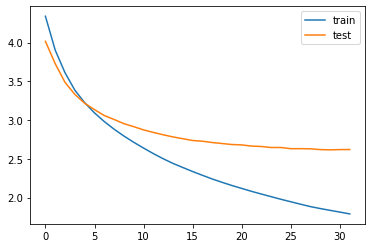

In [94]:
# 학습 그래프
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [95]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [96]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# code 7-10-3
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(max_text_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [97]:
encoder_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 60)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 60, 128)           3200000   
_________________________________________________________________
lstm_4 (LSTM)                [(None, 60, 256), (None,  394240    
Total params: 3,594,240
Trainable params: 3,594,240
Non-trainable params: 0
_________________________________________________________________


- embedding_4 레이어와 lstm_4 레이어는 위의 학습된 모델에서 가지고 온 것임

In [98]:
decoder_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 128)    1344000     input_14[0][0]                   
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 256)]        0                                            
___________________________________________________________________________________________

- embedding_5, lstm_5, attention_layer, dense_3 레이어 모두 위의 학습된 모델에서 가지고 온 것임

In [99]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    #print(input_seq)
    e_out, e_h, e_c = encoder_model.predict(input_seq) # 인코더 모델은 불완전한 구현이 아닌가?
    #print(e_out, e_out.shape)
    #print(e_h, e_h.shape)
    #print(e_c, e_c.shape)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (max_headlines_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [100]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    #print(input_seq)
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    #print(input_seq)
    temp=''
    for i in input_seq[1:]:
        if (i!=0):
            temp = temp + tar_index_to_word[i]+' '
    return temp

In [101]:
# 테스트
print("원문 :", seq2text(encoder_input_test[0]))
print("실제 요약 :", seq2summary(decoder_input_test[0]))
print("예측 요약 :", decode_sequence(encoder_input_test[0].reshape(1, max_text_len)))

원문 : billionaire lakshmi mittal led world largest steelmaker arcelormittal reportedly raised bid acquire essar steel crore earlier crore russia bank led consortium offered crore billionaire anil agarwal vedanta offered nearly crore debt laden company reports said essar steel owes creditors crore 
실제 요약 : raises essar steel bid to cr report 
예측 요약 :  tata steel to buy cr for cr in bid


### Extractive 요약

In [102]:
# 관련 라이브러리 -> 테스트 결과 요약이 안되는 것 같아 키워드 추출 라이브러리도 포함
from summa.summarizer import summarize
from summa.keywords import keywords

In [103]:
# 테스트
print("원문: ", data['text'][124])
print("실제 요약: ", data['headlines'][124])
print("Summa summarize: ", summarize(data['text'][124], ratio=0.1))
print("Summa keywords: ", keywords(data['text'][124]))

원문:  congress president rahul gandhi claimed goa cm manohar parrikar told nothing new rafale deal osd parrikar prasanna karthik called rahul compulsive liar karthik accused rahul shamelessly lying parrikar claiming wanted meet cm wish latter speedy recovery
실제 요약:  rahul gandhi is compulsive liar says goa cm osd
Summa summarize:  
Summa keywords:  parrikar
rahul
cm
claimed
claiming
karthik


### 종합 비교

In [106]:
for i in range(5):
    print("1) 원문: ", text_input_test[i])
    print("2) 전처리된 원문: ", seq2text(encoder_input_test[i]))
    print("3) 요약문: ", text_target_test[i])
    print("4) 전처리된 요약문: ", seq2summary(decoder_input_test[i]))
    print("5) 어텐션 모델 요약: ", decode_sequence(encoder_input_test[i].reshape(1, max_text_len)))
    print("6) Summa 모델 요약: ", summarize(text_input_test[i]))
    print("7) Summa 모델 키워드: ", keywords(text_input_test[i]))
    print("\n")

1) 원문:  billionaire lakshmi mittal led world largest steelmaker arcelormittal reportedly raised bid acquire essar steel crore earlier crore russia vtb bank led consortium offered crore billionaire anil agarwal vedanta offered nearly crore debt laden company reports said essar steel owes creditors crore
2) 전처리된 원문:  billionaire lakshmi mittal led world largest steelmaker arcelormittal reportedly raised bid acquire essar steel crore earlier crore russia bank led consortium offered crore billionaire anil agarwal vedanta offered nearly crore debt laden company reports said essar steel owes creditors crore 
3) 요약문:  arcelormittal raises essar steel bid to cr report eostoken
4) 전처리된 요약문:  raises essar steel bid to cr report 
5) 어텐션 모델 요약:   tata steel to buy cr for cr in bid
6) Summa 모델 요약:  
7) Summa 모델 키워드:  crore
reportedly
reports
led
offered
essar
billionaire


1) 원문:  punjab cm captain amarinder singh tuesday said student unions across state colleges universities allowed hold direct el

### 회고
- Summa 모델이 요약을 전혀 해주지 못하고 있습니다.
문장이 짧아서 요약을 하지 못하는 것이 아닌가 예상됩니다.
공식 홈페이지에서도 자세한 사용법을 찾을 수 없어 원인 분석 어려웠습니다.
- Attention 모델도 요약이 잘 되고 있다는 생각은 안 듭니다.
레이어 수나 하이퍼파라미터 조정 후 추가 테스트를 하면 좋을 것 같습니다.